This notebook gives an overview of the lstm neural network simulation

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *

Data:

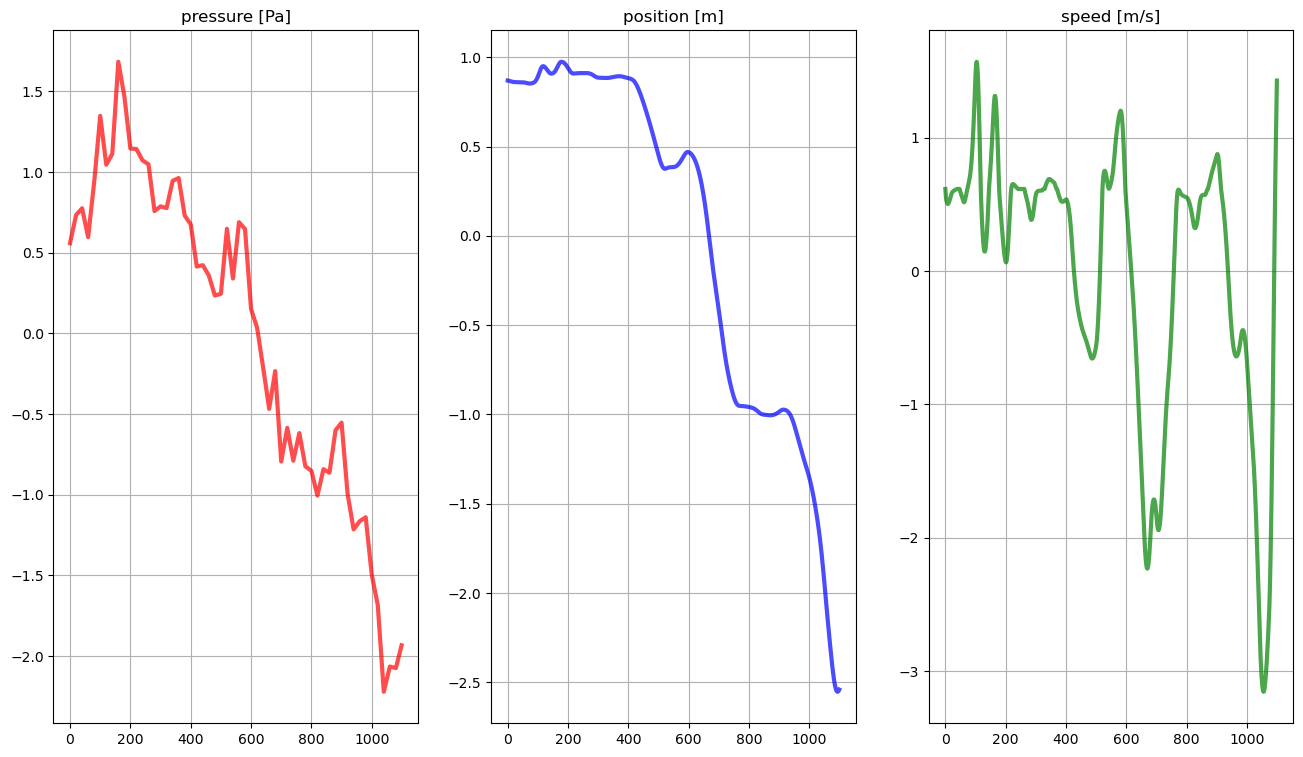

In [9]:
# Import the data generated via matlab/simulink:

# see get_data.py for more info
data_tensor = get_data(path = "save_data_test3.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 0, drop_half_timesteps = False, normalise_s_w=True, rescale_p=False, num_inits=0)

# View an example of a simulation run
visualise(data_tensor, num_inits=100)

LSTM - neural network


In [3]:
 #Define the LSTM model class

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

class LSTMmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.act = nn.ReLU()
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        #lstm_out = self.act(lstm_out)
        pred = self.linear(lstm_out)

        return pred, hidden


class GRUmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        # Define LSTM layer
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        pred = self.linear(lstm_out)

        return pred, hidden


cpu


Functions for training and testing the model:

In [12]:

def train(input_data, model, weight_decay, future_decay, learning_rate=0.001):
    """
    Train the LSTM model using input data.

    Args:
    - input_data: Input data for training
    - model: LSTM model to be trained
    - ws: Window size
    - odestep: Option for using ODE steps
    - use_autograd: Option for using autograd

    Returns:
    - Mean loss over all batches
    """
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

    model.train()
    total_loss = []

    for k, (inp, label) in enumerate(input_data):  # inp = (u, x) label = x
        
        inp=inp.to(device)
        label=label.to(device)

        # Predict one timestep :
        output, _ = model(inp)
        out = inp[:, :, 1:] + output

        print("inp", inp, inp.size())
        print("label", label, label.size())
        print("out", out, out.size())

        new_combined_inp = torch.cat((label[:, 0, 0:1], out[:,-1,:].clone()), dim=1)
        new_combined_inp = new_combined_inp.view(1,1,3)

        print("new_combined_inp", new_combined_inp, new_combined_inp.size())

        inp2 = torch.cat((inp[-1: ,1:,:], new_combined_inp), dim =1)        
        print("inp2" , inp2, inp2.size())

        output2, _ = model(inp2)
        out2 = inp2[:, :, 1:] + output2

        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        # calculate the error
        loss = loss_fn(out[:,-1,:], label[:, 0, 1:])
        loss2 = loss_fn(out2[:,-1,:], label[:, 1, 1:])
        #backpropagation
        loss.backward(retain_graph=True)
        optimizer.step()


        total_loss.append(loss.detach().cpu().numpy())

   # return the average error of the next step prediction
    return np.mean(total_loss)


In [5]:

def test(test_data, model, steps=600, ws=10, plot_opt=False):

    #test_data = test_dataloader.get_all_data() 
    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    total_loss = 0

    ids = np.random.randint(0, test_data.size(dim=0), 20)
    ids = np.unique(ids)

    for i, x in enumerate(test_data):
        x=x.to(device)
        if i not in ids:
            continue

        with torch.inference_mode():

            pred = torch.zeros((steps, 3), device=device)
            pred_next_step = torch.zeros((steps, 3), device=device)

            if ws > 1:
                pred[0:ws, :] = x[0:ws, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0:ws, :] = x[0:ws, :]
                pred_next_step[:, 0] = x[:, 0]
            else:
                pred[0, :] = x[0, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0, :] = x[0, :]
                pred_next_step[:, 0] = x[:, 0]

            for i in range(len(x) - ws):

                out, _ = model(pred[i:i+ws, :])
                pred[i+ws, 1:] = pred[i+ws-1, 1:] + out[-1, :]
                pred_next_step[i+ws, 1:] = x[i+ws-1, 1:] + out[-1, :]
            
            test_loss += loss_fn(pred[:, 1], x[:, 1]).detach().cpu().numpy()
            test_loss_deriv += loss_fn(pred[:, 2], x[:, 2]).detach().cpu().numpy()

            total_loss += loss_fn(pred[:, 1:], x[:, 1:]).detach().cpu().numpy()

            if plot_opt:
                figure , axs = plt.subplots(1,3,figsize=(16,9))
            
                axs[0].plot(pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
                axs[0].plot(pred_next_step.detach().cpu().numpy()[:, 1], color="green", label="next step from data")
                axs[0].plot(x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
                axs[0].set_title("position")
                axs[0].grid()
                axs[0].legend()

                axs[1].plot(pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
                axs[1].plot(pred_next_step.detach().cpu().numpy()[:, 2], color="green", label="next step from data")
                axs[1].plot(x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
                axs[1].set_title("speed")
                axs[1].grid()
                axs[1].legend()

                axs[2].plot(x.detach().cpu().numpy()[:,0], label="pressure")
                axs[2].set_title("pressure")
                axs[2].grid()
                axs[2].legend()

                plt.grid(True)
                plt.legend()
                plt.show()
            
    return np.mean(test_loss), np.mean(test_loss_deriv), np.mean(total_loss)


Main training loop:

generate parameters,
prepare training/testing data,
start training loop

In [13]:

# set some parameters for learning 
                    #window_size, h_size,  l_num,  epochs, learning_rate,  part_of_data,   weight_decay,   percentage_of_data    future_decay      batch_size
parameter_sets  =    [4,             5 ,      1,       20,       0.001,           10,           1e-5,               0.6,               0.3 ,           1]
                    
window_size, h_size, l_num, epochs, learning_rate, part_of_data, weight_decay,  percentage_of_data, future_decay, batch_size = parameter_sets

# Initialize the LSTM model
#model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
# Generate input data (the data is normalized and some timesteps are cut off)
input_data = get_data(path = "save_data_test3.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = False,
                        normalise_s_w=True,
                        rescale_p=False,
                        num_inits=part_of_data)

cut_off_timesteps = 1050

#Split data into train and test sets

num_of_inits_train = int(len(input_data)*percentage_of_data)
train_inits = np.random.randint(0,len(input_data), num_of_inits_train)
train_inits = np.unique(train_inits)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

# make sure we really get the specified percentage of training data..
if percentage_of_data < 0.99: 
        while len(train_inits) < num_of_inits_train:
            i = np.random.randint(0,len(test_inits),1)[0]
            train_inits = np.append(train_inits,test_inits[i])
            test_inits = np.delete(test_inits, i)

train_data = input_data[train_inits,:input_data.size(dim=1)-cut_off_timesteps,:]
test_data = input_data[test_inits,:,:]

data_set  = CustomDataset(train_data, window_size=window_size, future=2)
train_dataloader = DataLoader(data_set, batch_size=batch_size, pin_memory=True, drop_last=True)


losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(epochs)):
    
    loss_epoch = train(train_dataloader, model, weight_decay, future_decay, learning_rate=learning_rate)
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%2 == 0:
        _,_, err_train = test(train_data, model, steps=train_data.size(dim=1), ws=window_size, plot_opt=False)
        _,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False)
        average_traj_err_train.append(err_train)
        average_traj_err_test.append(err_test)
        print(f"Epoch: {epochs}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
        print(f"Average error over full trajectories: testing data : {err_test}")

  0%|          | 0/20 [00:00<?, ?it/s]

inp tensor([[[1.1196, 0.6979, 0.1911],
         [1.1345, 0.6980, 0.2330],
         [1.1494, 0.6984, 0.2672],
         [1.1643, 0.6990, 0.2993]]]) torch.Size([1, 4, 3])
label tensor([[[1.1792, 0.6998, 0.3319],
         [1.1941, 0.7008, 0.3658]]]) torch.Size([1, 2, 3])
out tensor([[[0.5001, 0.2116],
         [0.5168, 0.2627],
         [0.5245, 0.2931],
         [0.5298, 0.3205]]], grad_fn=<AddBackward0>) torch.Size([1, 4, 2])
new_combined_inp tensor([[[1.1792, 0.5298, 0.3205]]], grad_fn=<ViewBackward0>) torch.Size([1, 1, 3])
inp2 tensor([[[1.1345, 0.6980, 0.2330],
         [1.1494, 0.6984, 0.2672],
         [1.1643, 0.6990, 0.2993],
         [1.1792, 0.5298, 0.3205]]], grad_fn=<CatBackward0>) torch.Size([1, 4, 3])
inp tensor([[[1.1345, 0.6980, 0.2330],
         [1.1494, 0.6984, 0.2672],
         [1.1643, 0.6990, 0.2993],
         [1.1792, 0.6998, 0.3319]]]) torch.Size([1, 4, 3])
label tensor([[[1.1941, 0.7008, 0.3658],
         [1.2090, 0.7020, 0.4017]]]) torch.Size([1, 2, 3])
out tensor

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([[[1.2857, 0.8300, 1.5018],
         [1.2737, 0.8384, 1.5157]]]) torch.Size([1, 2, 3])
out tensor([[[0.6202, 1.4482],
         [0.6425, 1.4881],
         [0.6587, 1.5040],
         [0.6744, 1.5130]]], grad_fn=<AddBackward0>) torch.Size([1, 4, 2])
new_combined_inp tensor([[[1.2857, 0.6744, 1.5130]]], grad_fn=<ViewBackward0>) torch.Size([1, 1, 3])
inp2 tensor([[[1.3217, 0.8054, 1.4375],
         [1.3097, 0.8134, 1.4628],
         [1.2977, 0.8216, 1.4842],
         [1.2857, 0.6744, 1.5130]]], grad_fn=<CatBackward0>) torch.Size([1, 4, 3])
inp tensor([[[1.3217, 0.8054, 1.4375],
         [1.3097, 0.8134, 1.4628],
         [1.2977, 0.8216, 1.4842],
         [1.2857, 0.8300, 1.5018]]]) torch.Size([1, 4, 3])
label tensor([[[1.2737, 0.8384, 1.5157],
         [1.2617, 0.8469, 1.5259]]]) torch.Size([1, 2, 3])
out tensor([[[0.6294, 1.4743],
         [0.6527, 1.5094],
         [0.6699, 1.5210],
         [0.6865, 1.5258]]], grad_fn=<AddBackward0>) torch.Size([1, 4, 2])
new_combined_inp tensor(

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
# Save the model
path = f"Ventil_trained_NNs\my_example_model.pth"
torch.save(model.state_dict(), path)

# Load the model and test it on the test data

path = "Ventil_trained_NNs\my_example_model.pth"
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)
model.load_state_dict(torch.load(path, map_location=torch.device(device)))

test_loss, test_loss_deriv, total_loss = test(test_data, model, steps=input_data.size(dim=1), ws=window_size, plot_opt=True)
ic(test_loss, test_loss_deriv, total_loss)

In [ ]:
input_data = get_data(path = "save_data_test3.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = False,
                        normalise_s_w=True,
                        rescale_p=False,
                        num_inits=0)

#Split data into train and test sets
cut_off_timesteps = 900
percentage_of_data=0.8

print(input_data.size())
num_of_inits_train = int(len(input_data)*percentage_of_data)
train_inits = np.random.randint(0,len(input_data), num_of_inits_train)
train_inits = np.unique(train_inits)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

# make sure we really get the specified percentage of training data..
if percentage_of_data < 0.99: 
        while len(train_inits) < num_of_inits_train:
            i = np.random.randint(0,len(test_inits),1)[0]
            train_inits = np.append(train_inits, test_inits[i])
            test_inits = np.delete(test_inits, i)

train_data = input_data[train_inits,:input_data.size(dim=1)-cut_off_timesteps,:]
test_data = input_data[test_inits,:,:]

In [ ]:
#added comments
